In [1]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Conv2D, Flatten, Activation, Dense, Input
from keras.layers import Conv2DTranspose
from keras.layers import Reshape
import matplotlib.pyplot as plt
from keras.models import Model

Using TensorFlow backend.


In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

input_shape = (28, 28, 1)

x_train = x_train.reshape((x_train.shape[0], ) + input_shape ) 
x_test = x_test.reshape((x_test.shape[0], ) + input_shape)

In [16]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
noise_test = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)

In [17]:
x_train_with_noise = np.clip((x_train + noise), 0., 1.)
x_test_with_noise = np.clip((x_test + noise_test), 0., 1.)

In [18]:
x_test_with_noise.shape

(10000, 28, 28, 1)

In [19]:
def get_shape(layer):
    shape = ()
    for i in layer.shape:
        shape += (i.value, )
    return shape

In [24]:
#encoder
encoder_inputs = Input(shape=input_shape)
x = encoder_inputs
x = Conv2D(filters=32,
               kernel_size=(3, 3),
               activation='relu',
               strides = 2,
               padding='same')(x)
x = Conv2D(filters=64,
               kernel_size=(3, 3),
               activation='relu',
               strides = 2,
               padding='same')(x)
shape = get_shape(x)
x = Flatten()(x)
output = Dense(16)(x)
encoder = Model(encoder_inputs, output, name='encoder')

In [25]:
input_from_encoder = Input(shape=(16,))
x = Dense(shape[1] * shape[2] * shape[3])(input_from_encoder)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        strides = 2,
                        padding='same')(x)
x = Conv2DTranspose(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        strides = 2,
                        padding='same')(x)
x = Conv2DTranspose(filters=1,
                    kernel_size=(3, 3),
                    padding='same')(x)

output_image = Activation('sigmoid')(x)
decoder = Model(input_from_encoder, output_image, name='decoder')

In [26]:
autoencoder = Model(encoder_inputs, decoder(encoder(encoder_inputs)))

In [27]:
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
autoencoder.fit(x_train_with_noise,
                x_train,
                epochs=10,
                batch_size=256)

Epoch 1/10
60000/60000 [==============================] - 192s 3ms/step - loss: 0.0739 - acc: 0.8045
Epoch 2/10
60000/60000 [==============================] - 250s 4ms/step - loss: 0.0481 - acc: 0.7977
Epoch 3/10
60000/60000 [==============================] - 213s 4ms/step - loss: 0.0335 - acc: 0.8026
Epoch 4/10
60000/60000 [==============================] - 176s 3ms/step - loss: 0.0290 - acc: 0.8051
Epoch 5/10
60000/60000 [==============================] - 244s 4ms/step - loss: 0.0265 - acc: 0.8065
Epoch 6/10
60000/60000 [==============================] - 303s 5ms/step - loss: 0.0248 - acc: 0.8074
Epoch 7/10
60000/60000 [==============================] - 420s 7ms/step - loss: 0.0236 - acc: 0.8080
Epoch 8/10
60000/60000 [==============================] - 410s 7ms/step - loss: 0.0227 - acc: 0.8085
Epoch 9/10
60000/60000 [==============================] - 297s 5ms/step - loss: 0.0221 - acc: 0.8088
Epoch 10/10
60000/60000 [==============================] - 234s 4ms/step - loss: 0.0215 - a

In [28]:
test_image = x_test_with_noise[0]

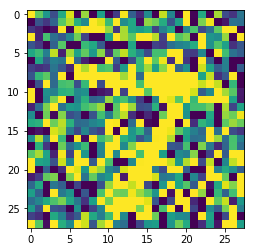

In [29]:
plt.imshow(test_image[:, :, 0])

In [30]:
clean = autoencoder.predict(test_image.reshape(1, 28, 28, 1))

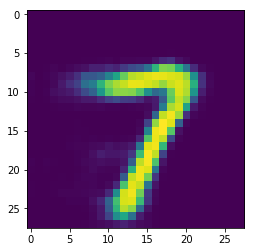

In [31]:
plt.imshow(clean[0, :, :, 0])

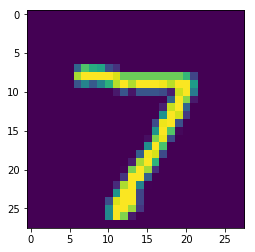

In [36]:
plt.imshow(x_test[0].reshape(28, 28))

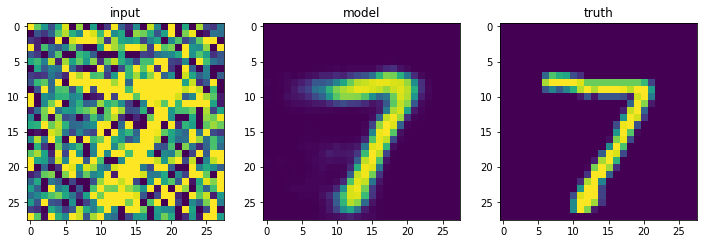

In [38]:
figure, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].set_title("input")
axes[0].imshow(test_image[:, :, 0])
axes[1].set_title("model")
axes[1].imshow(clean[0, :, :, 0])
axes[2].set_title("truth")
axes[2].imshow(x_test[0].reshape(28, 28))